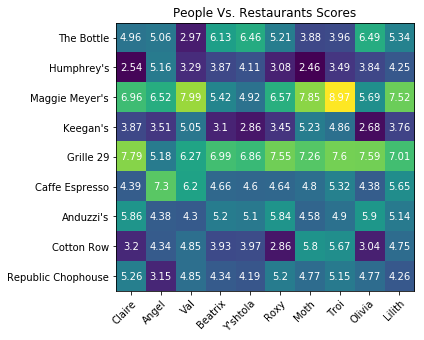

In [6]:
import numpy as np
from scipy.stats import rankdata
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import pairwise_distances_argmin
from sklearn.decomposition import PCA
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn import metrics
import matplotlib.cm as cm
from sklearn.metrics import davies_bouldin_score
from sklearn.metrics import silhouette_samples, silhouette_score

import sys
orig_stdout = sys.stdout
f = open('MacVittie_Hmwk3_Output.txt', 'w')
sys.stdout = f

# rather than come up with values myself, I'll randomly generate a bunch, but I want them *consistent* over time, so set the seed.
# we also need them to be consistent so that we can answer some of the actual homework questions.
np.random.seed(0xdedede)

def makeDict(names, categories, varType):
	types = {}
	
	for n in names:
		if varType == 'float':
			while True:
				random_prefs = np.random.dirichlet(np.ones(len(categories)),size=1)
				random_prefs = random_prefs.reshape(len(categories),)
				random_prefs = np.around(random_prefs, decimals = 2)
				
				sum = 0.0
				isZero = False
				
				for p in random_prefs:
					sum += p
					
					if(p == 0.0):
						isZero = True
							
				if(sum == 1.0 and not isZero):
					break;
		elif varType == 'int':
			random_prefs = np.random.randint(1, 11, len(categories))
			
		dict_input = dict(zip(categories, random_prefs))
		types[n] = dict_input
	return types

def listToMatrix(list):
	list_of_lists = []
	for names, choices in list.items():
		passing_list = []
		for choice in choices:
			try:
				passing_list.append(choices[choice])
			except KeyError:
				passing_list.append(0)
		list_of_lists.append(passing_list)
		
	passing_list_array = np.array(list_of_lists)
	return(passing_list_array)
    
def dataProcessing(people, restaurants, names):
	new_people = np.swapaxes(people, 0, 1)
	people_X_restaurants = np.dot(restaurants, new_people)
	restaurants_sum = np.sum(people_X_restaurants, axis=1)
	ranks = rankdata(restaurants_sum, method='max').reshape(restaurants_sum.shape)
	
	print(ranks, "\n")
	
	rankMatrix = createRankMatrix(names, ranks)
	usr_x_rest_rank = sorted(rankMatrix.items(), key=lambda kv: kv[1])
	
	return (people_X_restaurants, rankMatrix, usr_x_rest_rank)

def createRankMatrix(names, ranks):
	rankMatrix = {}
	
	for i in range(len(ranks)):
		name = names[i]
		rank = ranks[i]
		rankMatrix[name] = rank
	
	return rankMatrix

def buildDentogram(fitMatrix, label, title):
	pca = PCA(n_components=2)  
	PcaTransform = pca.fit_transform(fitMatrix)  
	
	linked = linkage(PcaTransform, 'single')
	fig = plt.figure(figsize=(17, 7))
	ax = fig.add_subplot(1, 1, 1)
	dendrogram(linked,  
				orientation='top',
				labels=label,
				distance_sort='descending',
				show_leaf_counts=True, ax=ax)
	
	ax.set_title(title)
	ax.tick_params(axis='x', which='major', labelsize=15)
	ax.tick_params(axis='y', which='major', labelsize=15)
	plt.show()  
	
	return

def knn2to4(fitMatrix,subtitle):
	n_clusters = 1
	colors = ['#4EACC5', '#FF9C34', '#4E9A06','#377eb8']
	
	fig = plt.figure(figsize=(8, 5))
	fig.subplots_adjust(left=0.02, right=0.98, bottom=0.05, top=0.9)
	plt.suptitle(subtitle)
	
	for i in range(3):
		ax = fig.add_subplot(1, 3, n_clusters)
		n_clusters = n_clusters+1
		
		kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(fitMatrix)
		k_means_cluster_centers = np.sort(kmeans.cluster_centers_, axis=0)
		k_means_labels = pairwise_distances_argmin(fitMatrix, k_means_cluster_centers)
		
		for k, col in zip(range(n_clusters), colors):
			my_members = k_means_labels == k
			cluster_center = k_means_cluster_centers[k]
			ax.plot(fitMatrix[my_members, 0], fitMatrix[my_members, 1], 'w', markerfacecolor=col, marker='.', markersize=12)
			ax.plot(cluster_center[0], cluster_center[1], 'o', markerfacecolor=col, markeredgecolor='k', markersize=15)
			
			ax.set_title('KMeans - %i' %n_clusters)
			ax.set_xticks(())
			ax.set_yticks(())
			
	plt.show()
	plt.close()
	
	return

# Code Reference
# https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html#sphx-glr-auto-examples-cluster-plot-kmeans-silhouette-analysis-py
def checkMaxClusters(fitMatrix): 
    
    range_n_clusters = [2, 3, 4]
    print("")
    print("Silhouette scores are between -1 to +1")
    print("-1: Incorrect, 0: Overlapping  & +1: Highly densed Clustering")
    print("Purity of the cluster is measured with higher score which also means well separated and highly densed")
    print("")
        
    for n_clusters in range_n_clusters:
        fig, (ax1, ax2) = plt.subplots(1, 2)
        fig.set_size_inches(18, 7)
        ax1.set_xlim([-0.1, 1])
        ax1.set_ylim([0, len(fitMatrix) + (n_clusters + 1) * 10])
        clusterer = KMeans(n_clusters=n_clusters, random_state=10)
        cluster_labels = clusterer.fit_predict(fitMatrix)
        silhouette_avg = silhouette_score(fitMatrix, cluster_labels)
        sample_silhouette_values = metrics.silhouette_samples(fitMatrix, cluster_labels)
        
        print("For n_clusters =", n_clusters,
              "\n The average silhouette_score is :", silhouette_avg,
              "\n Individual silhouette scores were:", sample_silhouette_values,
              "\n and their assigned clusters:", cluster_labels)
        print("")
        
        sample_silhouette_values = silhouette_samples(fitMatrix, cluster_labels)
        y_lower = 10
        for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
            ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

            ith_cluster_silhouette_values.sort()

            size_cluster_i = ith_cluster_silhouette_values.shape[0]
            y_upper = y_lower + size_cluster_i

            color = cm.nipy_spectral(float(i) / n_clusters)
            ax1.fill_betweenx(np.arange(y_lower, y_upper),
                              0, ith_cluster_silhouette_values,
                              facecolor=color, edgecolor=color, alpha=0.7)

            # Label the silhouette plots with their cluster numbers at the middle
            ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
        
            # Compute the new y_lower for next plot
            y_lower = y_upper + 10  # 10 for the 0 samples

            ax1.set_title("The silhouette plot for the various clusters.")
            ax1.set_xlabel("The silhouette coefficient values")
            ax1.set_ylabel("Cluster label")

            # The vertical line for average silhouette score of all the values
            ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

            ax1.set_yticks([])  # Clear the yaxis labels / ticks
            ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

            # 2nd Plot showing the actual clusters formed
            colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
            ax2.scatter(fitMatrix[:, 0], fitMatrix[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                        c=colors, edgecolor='k')

            # Labeling the clusters
            centers = clusterer.cluster_centers_
            # Draw white circles at cluster centers
            ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                        c="white", alpha=1, s=200, edgecolor='k')
            
            for i, c in enumerate(centers):
                ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                            s=50, edgecolor='k')
                
                ax2.set_title("The visualization of the clustered data.")
                ax2.set_xlabel("Feature space for the 1st feature")
                ax2.set_ylabel("Feature space for the 2nd feature")
                
                plt.suptitle(("Silhouette analysis for KMeans clustering "
                              "with n_clusters = %d" % n_clusters),
                     fontsize=14, fontweight='bold')
        
    plt.show()
    return
  
def checkClusterPurity(fitMatrix):
    
    range_n_clusters = [2, 3, 4]
    print("Davies Bouldin Score: Lower means better separated, zero is the lowest")
    print("Calinski Harabaz Score: Higher means dense and well separated")
    print("")
    print("No. of Clusters\t\tCalinski Harabaz Index\t\tDavies Bouldin Score")
    for n_clusters in range_n_clusters:
        
        pca = PCA(n_components=n_clusters)
        mPeopleXRestaurantsPcaTransform = pca.fit_transform(fitMatrix) 
        kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(mPeopleXRestaurantsPcaTransform)
        k_means_cluster_labels = kmeans.predict(mPeopleXRestaurantsPcaTransform)
        print("\t", n_clusters, 
              "\t\t", metrics.calinski_harabaz_score(mPeopleXRestaurantsPcaTransform, k_means_cluster_labels),
              "\t\t",davies_bouldin_score(mPeopleXRestaurantsPcaTransform, k_means_cluster_labels))
        
    return

print("MACVITTIE - HOMEWORK 3")
print("Using randomized weights and scores, for the lawlz.\n")

p_names = ['Claire', 'Angel', 'Val', 'Beatrix', 'Y\'shtola', 'Roxy', 'Moth', 'Troi', 'Olivia', 'Lilith']
p_cats = ['Willingness to Travel', 'Desire for New Experience', 'Cost', 'Pickiness', 'Service', 'Vegetarian']

people = makeDict(p_names, p_cats, 'float')

M_people = listToMatrix(people)
print ("== People ==")
print(p_names)
print("The names used here are NPCs from my D&D setting (some of which may be borrowed from other sources).\n")
print("== Preferences ==")
print(p_cats, "\n")

print("---== People Matrix ==---")
print(M_people, "\n")

r_names = ['The Bottle', 'Humphrey\'s', 'Maggie Meyer\'s', 'Keegan\'s', 'Grille 29', 'Caffe Espresso', 'Anduzzi\'s', 'Cotton Row', 'Republic Chophouse']
r_cats = ['Distance', 'Novelty', 'Cost', 'Menu Options', 'Staff', 'Vegetarian']

restaurants = makeDict(r_names, r_cats, 'int')

M_rest = listToMatrix(restaurants)

print("== Restaurants ==")
print(r_names)
print("The names of these restaurants come from the city I currently live in, and the restaurants I worked in when I was a chef.\n")
print("== Attributes ==")
print(r_cats, "\n")

print("---== Restaurant Matrix ==---")
print(M_rest, "\n")

print("> The most important idea in this project is the idea of a linear combination.")
print("> Informally describe what a linear combination is and how it will relate to our restaurant matrix.\n")
print("Linear combination takes two equations and simplifies, removing one variable.\nHere, we want to take in the preferences of the people and attributes of the restaurants, and arrive at a rank.\n")

M_pplXrst, rankMatrix, M_usr_x_rest_rank = dataProcessing(M_people, M_rest, r_names)

print("== Restaurant Rankings by Person ==")
print(M_pplXrst, "\n")

print("Each row is a restaurant, while each column is an individual.\nEach cell represents the rank of the given restaurant for that individual.\n")

print("The sum of each row represents its score for the group as a whole, on a scale of 0 to 100.\n")

print(r_names)
print(np.sum(M_pplXrst, axis=1))
print("")

print("-- Restaurant Preferences --")

M_restaurant_max = np.argmax(M_pplXrst, axis=1);
M_people_max = np.argmax(M_pplXrst, axis=0);

print("> Choose a person and compute(using a linear combination) the top restaurant for them.  What does each entry in the resulting vector represent.")
for i in range(0, 9):
	print ("[" + p_names[0] + "]", "has a score for", "[" + r_names[i] + "]", "of", M_pplXrst[i][0])
	
print("")

print("Each value in this vector represents Claire's combined preference for the restaurant in question,\ncombining her preferences with the attributes of the restaurant.\n\nThe following list each individual's preferred restaurant.")

for i in range(len(M_people_max)):
    print ("[" + p_names[i] + "]", "prefers", "[" + r_names[M_people_max[i]] + "]")

print("")    

print("Which restaurant got the best rating, and who had the strongest preference for it?\n")

for i in range(len(M_restaurant_max)):
    print ("[" + r_names[i] + "]", "is most strongly preferred by", "[" + p_names[M_restaurant_max[i]] + "]")

print("")
	
print("> Now convert each row in the M_usr_x_rest into a ranking for each user and call it M_usr_x_rest_rank.") 
print("> Do the same as above to generate the optimal restaurant choice\n")	

print(M_usr_x_rest_rank, "\n")

print("> Why is there a difference between the two?  What problem arrives?  What does represent in the real world?\n")

print("After being confused by the output for a moment, these are in descending order (so 9 is best, 1 is worst). This means that our results match up with what we saw in the summarized matrix, above.\n")
print("Given how the ranks are generated, I'm not sure there is a way that a difference could show up between the rankings and the preference matrix; or, if there is, it is probably due to extreme outliers: people who value one attribute significantly higher than all others.")

fig, ax = plt.subplots(figsize=(6, 6))
plt.imshow(M_pplXrst)
ax.set_xticks(np.arange(len(p_names)))
ax.set_yticks(np.arange(len(r_names)))

ax.set_xticklabels(p_names)
ax.set_yticklabels(r_names)

plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

for i in range(9):
	for j in range(10):
		text = ax.text(j, i, round(M_pplXrst[i, j],2),
			ha="center", va="center", color="w")

ax.set_title('People Vs. Restaurants Scores') 
fig.tight_layout()
plt.show()
plt.close()

In [4]:
plt.show()

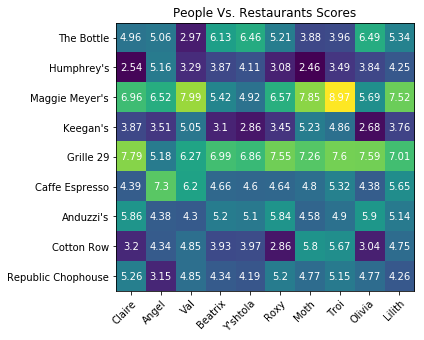

In [5]:
fig, ax = plt.subplots(figsize=(6, 6))
plt.imshow(M_pplXrst)
ax.set_xticks(np.arange(len(p_names)))
ax.set_yticks(np.arange(len(r_names)))

ax.set_xticklabels(p_names)
ax.set_yticklabels(r_names)

plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

for i in range(9):
	for j in range(10):
		text = ax.text(j, i, round(M_pplXrst[i, j],2),
			ha="center", va="center", color="w")

ax.set_title('People Vs. Restaurants Scores') 
fig.tight_layout()
plt.show()

In [7]:
print(people)

In [8]:
print(restaurants)

In [1]:
import sys
print(sys.version)

3.6.6 | packaged by conda-forge | (default, Jul 26 2018, 11:48:23) [MSC v.1900 64 bit (AMD64)]
